# <center>A Notebook to Compare Linear Regression and XGBoost Models in Calculating Auto Insurance CLV</center>

### Import all of the necessary packages ###

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import xgboost
import math
import seaborn as sns
from sklearn.model_selection import GridSearchCV




### Read in the data and convert categorical variables to dummy variables ###

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv')

In [3]:
dummy_var_df = pd.get_dummies(df, columns=["Renew Offer Type", "Sales Channel","Policy", "Policy Type","Vehicle Class", "Vehicle Size", "State", "Response", "Coverage", "Education", "Gender", "Location Code", "EmploymentStatus", "Marital Status"])

In [4]:
new_df = dummy_var_df.select_dtypes(exclude = "object")

### Retrieve feature set and calculate correlations

In [5]:
y_var = new_df['Customer Lifetime Value']

In [6]:
#Excluding certain variables to reduce dummy variable bias
x_var = new_df.loc[:, ~new_df.columns.isin(['Total Claim Amount','Marital Status_Single','EmploymentStatus_Unemployed','Location Code_Urban','Gender_M','Education_Master','Coverage_Premium','Response_Yes','Vehicle Size_Small',"Policy_Special L2",'Renew Offer Type_Offer4','Number of Open Complaints','Customer Lifetime Value', 'Months Since Last Claim', 'Months Since Policy Inception'])]

In [7]:
feature_corr = x_var.corrwith(y_var)

In [8]:
x_var.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Income                          9134 non-null   int64
 1   Monthly Premium Auto            9134 non-null   int64
 2   Number of Policies              9134 non-null   int64
 3   Renew Offer Type_Offer1         9134 non-null   bool 
 4   Renew Offer Type_Offer2         9134 non-null   bool 
 5   Renew Offer Type_Offer3         9134 non-null   bool 
 6   Sales Channel_Agent             9134 non-null   bool 
 7   Sales Channel_Branch            9134 non-null   bool 
 8   Sales Channel_Call Center       9134 non-null   bool 
 9   Sales Channel_Web               9134 non-null   bool 
 10  Policy_Corporate L1             9134 non-null   bool 
 11  Policy_Corporate L2             9134 non-null   bool 
 12  Policy_Corporate L3             9134 non-null   bool 
 13  Pol

<Axes: title={'center': 'Variables with a Correlation Coefficient Above .02'}, xlabel='Variable', ylabel='Correlation'>

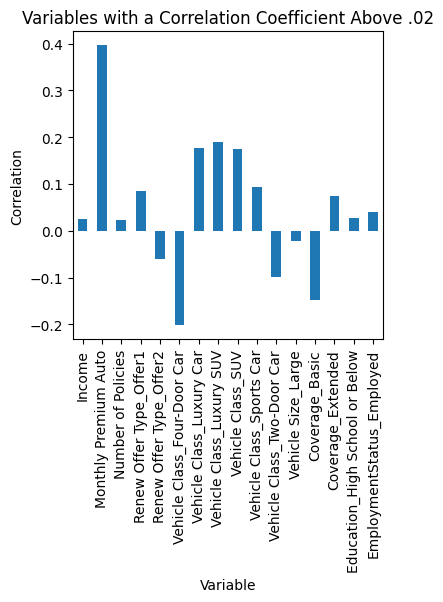

In [9]:
feature_corr[abs(feature_corr)>.02].plot(kind = 'bar', legend = False, title = "Variables with a Correlation Coefficient Above .02", ylabel = 'Correlation', xlabel = 'Variable',figsize = (4,4), fontsize = 10)

In [10]:
x_var_curated = x_var[feature_corr[abs(feature_corr)>.02].index]
# Only choosing features with "high" correlation

In [11]:
x_var_curated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Income                          9134 non-null   int64
 1   Monthly Premium Auto            9134 non-null   int64
 2   Number of Policies              9134 non-null   int64
 3   Renew Offer Type_Offer1         9134 non-null   bool 
 4   Renew Offer Type_Offer2         9134 non-null   bool 
 5   Vehicle Class_Four-Door Car     9134 non-null   bool 
 6   Vehicle Class_Luxury Car        9134 non-null   bool 
 7   Vehicle Class_Luxury SUV        9134 non-null   bool 
 8   Vehicle Class_SUV               9134 non-null   bool 
 9   Vehicle Class_Sports Car        9134 non-null   bool 
 10  Vehicle Class_Two-Door Car      9134 non-null   bool 
 11  Vehicle Size_Large              9134 non-null   bool 
 12  Coverage_Basic                  9134 non-null   bool 
 13  Cov

### Splitting into training and testing data ###

In [12]:
(X_train, X_test, y_train, y_test) = train_test_split(x_var, y_var)

In [13]:
(X_train_curated, X_test_curated, y_train_curated, y_test_curated) = train_test_split(x_var_curated, y_var)

### Training two linear models, one with full feature set and one with curated feature set

In [14]:
model1 = sm.OLS(y_train, np.array(X_train).astype(np.float64)).fit()

In [15]:
model2 = sm.OLS(y_train_curated, np.array(X_train_curated).astype(np.float64)).fit()

In [16]:
print(model1.summary()) #Full feature set

                               OLS Regression Results                              
Dep. Variable:     Customer Lifetime Value   R-squared:                       0.165
Model:                                 OLS   Adj. R-squared:                  0.160
Method:                      Least Squares   F-statistic:                     30.63
Date:                     Tue, 09 May 2023   Prob (F-statistic):          1.31e-229
Time:                             13:16:56   Log-Likelihood:                -69672.
No. Observations:                     6850   AIC:                         1.394e+05
Df Residuals:                         6805   BIC:                         1.397e+05
Df Model:                               44                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1

In [17]:
print(model2.summary()) #Curated feature set

                               OLS Regression Results                              
Dep. Variable:     Customer Lifetime Value   R-squared:                       0.170
Model:                                 OLS   Adj. R-squared:                  0.168
Method:                      Least Squares   F-statistic:                     93.29
Date:                     Tue, 09 May 2023   Prob (F-statistic):          1.77e-262
Time:                             13:16:56   Log-Likelihood:                -69775.
No. Observations:                     6850   AIC:                         1.396e+05
Df Residuals:                         6834   BIC:                         1.397e+05
Df Model:                               15                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1

### XGBoost model training and parameter grid search

In [18]:
model = xgboost.XGBRegressor()

In [19]:
param_grid = {
    'max_depth': [3, 5,7,10],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 150],
    'gamma': [0, 0.1, 0.2],
}
grid_search = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print best hyperparameters and corresponding mean test score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

Best hyperparameters:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best score:  -0.6746880834184122


In [34]:
model_xgb = xgboost.XGBRegressor(gamma = 0, learning_rate = .1, max_depth = 5, n_estimators = 50)
model_xgb_c = xgboost.XGBRegressor(gamma = 0, learning_rate = .1, max_depth = 5, n_estimators = 50)

In [35]:
model_xgb_c.fit(np.array(X_train_curated).astype(np.float64), y_train_curated)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [36]:
model_xgb.fit(np.array(X_train).astype(np.float64), y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [37]:
y_test_new = np.array(y_test)

In [38]:
y_test_new_c = np.array(y_test_curated)

In [39]:
y_pred_o = np.array(model1.predict(X_test)) # normal predictions - linear

In [40]:
y_pred_o_c = np.array(model2.predict(X_test_curated)) # curated predictions - linear

In [41]:
y_pred = np.array(model_xgb.predict(X_test)) # normal predictions - XGB

In [42]:
y_pred_c = np.array(model_xgb_c.predict(X_test_curated)) # curated predictions - XGB

### Printing linear model error

In [43]:
square_error = 0
abs_error=0
for i in range(len(y_test)):
    square_error += (y_pred_o_c[i] - y_test_new_c[i])**2
    abs_error += abs(y_pred_o_c[i] - y_test_new_c[i])
avg_error = square_error/len(y_test)
avg_abs_error = abs_error/len(y_test)
print('square error', avg_error)
print('absolute error', avg_abs_error)

square error 34234487.96104631
absolute error 3776.1037701014325


In [51]:
square_error = 0
abs_error=0
for i in range(len(y_test)):
    square_error += (y_pred_o[i] - y_test_new[i])**2
    abs_error += abs(y_pred_o[i] - y_test_new[i])
avg_error = square_error/len(y_test)
avg_abs_error = abs_error/len(y_test)
print('square error', avg_error)
print('absolute error', avg_abs_error)

square error 37344220.74466683
absolute error 3771.191551193348


In [52]:
print('average CLV',np.average(y_test_new))

average CLV 8034.146618654991


### Printing curated XGBoost model error

In [46]:
abs_error = 0
square_error = 0
for i in range(len(y_test)):
    square_error += (y_pred_c[i] - y_test_new_c[i])**2
    abs_error += abs(y_pred_c[i] - y_test_new_c[i])
avg_error = square_error/len(y_test)
avg_abs_error = abs_error/len(y_test)
print('square error', avg_error)
print('absolute error',avg_abs_error)

square error 12731597.249467697
absolute error 1564.515252444091


### Calculating point breakdown for XGBoost Model

In [48]:
abs_error = 0
square_error = 0

within_5000_pred = []
within_10000_pred = []
greater_than_10000_pred = []
within_5000_true = []
within_10000_true = []
greater_than_10000_true = []
good_count = 0 
med_count = 0
bad_count =  0
total_error = 0
neg_outlier = 0
pos_outlier = 0
neg_decent = 0
pos_decent = 0
for i in range(len(y_test)):
    abs_error =  abs(y_pred[i] - y_test_new[i])
    total_error+=abs_error
    if(abs_error<3000):
        good_count +=1
        within_5000_pred.append(y_pred[i])
        within_5000_true.append(y_test_new[i])
    elif(abs_error<6000):
        if(y_pred[i] - y_test_new[i]<0):
            neg_decent +=1
        else:
            pos_decent+=1
        within_10000_pred.append(y_pred[i])
        within_10000_true.append(y_test_new[i])
        med_count+=1
    else:
        if(y_pred[i] - y_test_new[i]<0):
            neg_outlier +=1
        else:
            pos_outlier+=1
        greater_than_10000_pred.append(y_pred[i])
        greater_than_10000_true.append(y_test_new[i])
        bad_count+=1
            
print('good count, decent count, bad count' , good_count, med_count, bad_count)
print('absolute error', total_error/len(y_test))
print('outlier counts', neg_decent, pos_decent, neg_outlier, pos_outlier)


good count, decent count, bad count 1804 298 182
absolute error 1635.6976296753958
outlier counts 31 267 123 59


### Calculating counts for linear model and plotting graphs

good count, decent count, bad count 1326 657 301
outlier counts 234 423 225 76


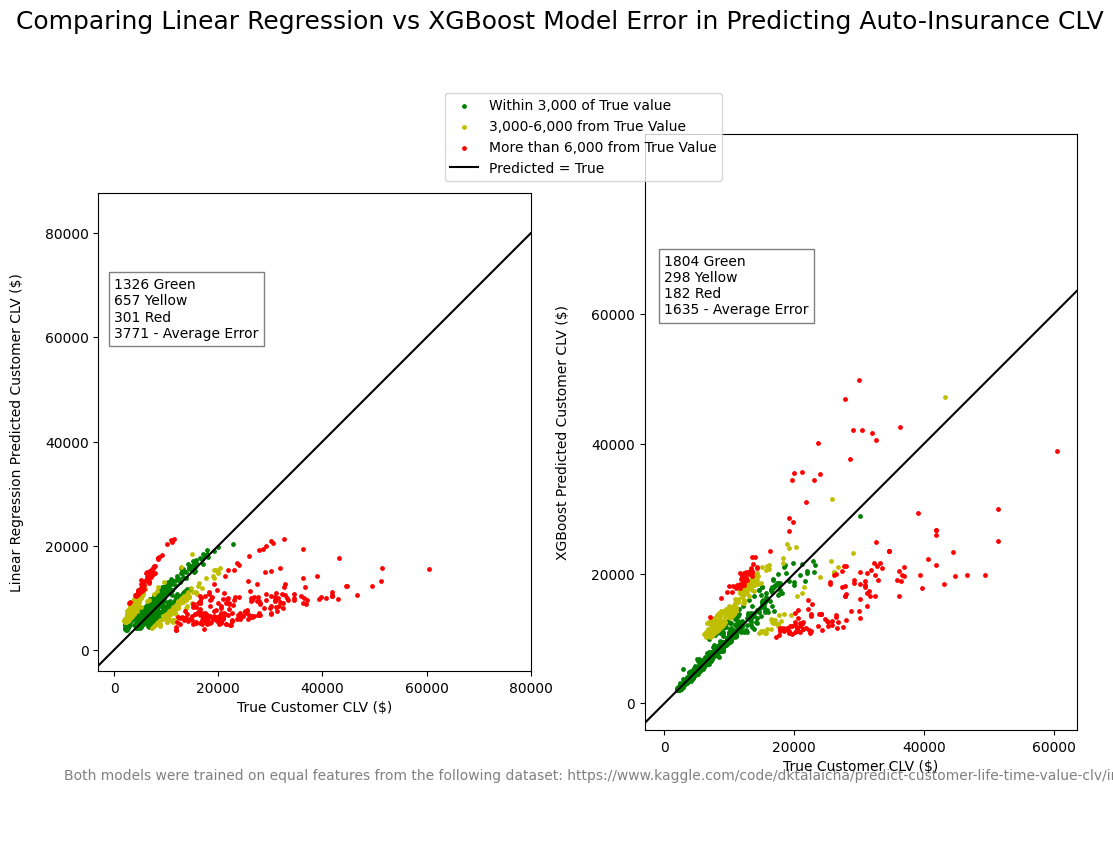

In [53]:
fig, (ax1, ax2) = pyplot.subplots(1,2, figsize = (12,9))
fig.tight_layout(pad = 6)

ax2.scatter(within_5000_true, within_5000_pred, label = 'Within 3,000 of True value', c = 'g', s = 6)
ax2.scatter(within_10000_true, within_10000_pred, c = 'y', label = '3,000-6,000 from True Value', s = 6)
ax2.scatter(greater_than_10000_true, greater_than_10000_pred, c = 'r', label = 'More than 6,000 from True Value', s = 6)
ax2.scatter(0,83500, c='w')
ax2.set_xlabel('True Customer CLV ($)')
ax2.set_ylabel('XGBoost Predicted Customer CLV ($)', labelpad = 15)
#pyplot.title('XGBoost Model Results in Predicting Auto-Insurance CLV')
ax2.axline([0, 0], slope=1, c = 'k', label = 'Predicted = True')
#pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#ax1.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0, prop = {'size': 8})
ax2.yaxis.set_ticks(np.arange(0, 80001, 20000))
ax2.xaxis.set_ticks(np.arange(0, 80001, 20000))
ax2.set_aspect('equal')
ax2.text(0, 60000, '1804 Green \n298 Yellow \n182 Red \n1635 - Average Error' , fontsize = 10, 
         bbox = dict(facecolor = 'white', alpha = 0.5))
ax1.text(0, 60000, '1326 Green \n657 Yellow \n301 Red \n3771 - Average Error' , fontsize = 10, 
         bbox = dict(facecolor = 'white', alpha = 0.5))
abs_error = 0
square_error = 0

within_5000_pred_o = []
within_10000_pred_o = []
greater_than_10000_pred_o = []
within_5000_true_o = []
within_10000_true_o = []
greater_than_10000_true_o = []
good_count2 = 0 
med_count2 = 0
bad_count2 =  0
neg_outlier = 0
pos_outlier = 0
neg_decent = 0
pos_decent = 0
for i in range(len(y_test)):
    abs_error =  abs(y_pred_o[i] - y_test_new[i])
    if(abs_error<3000):
        good_count2 +=1
        within_5000_pred_o.append(y_pred_o[i])
        within_5000_true_o.append(y_test_new[i])
    elif(abs_error<6000):
        if(y_pred[i] - y_test_new[i]<0):
            neg_decent +=1
        else:
            pos_decent+=1
        within_10000_pred_o.append(y_pred_o[i])
        within_10000_true_o.append(y_test_new[i])
        med_count2+=1
    else:
        if(y_pred[i] - y_test_new[i]<0):
            neg_outlier +=1
        else:
            pos_outlier+=1
        greater_than_10000_pred_o.append(y_pred_o[i])
        greater_than_10000_true_o.append(y_test_new[i])
        bad_count2+=1
print('good count, decent count, bad count' ,good_count2, med_count2, bad_count2)
print('outlier counts',neg_decent, pos_decent, neg_outlier, pos_outlier)
ax1.scatter(within_5000_true_o, within_5000_pred_o, label = 'Within 3,000 of True value', c = 'g', s = 6)
ax1.scatter(within_10000_true_o, within_10000_pred_o, c = 'y', label = '3,000-6,000 from True Value', s = 6)
ax1.scatter(greater_than_10000_true_o, greater_than_10000_pred_o, c = 'r', label = 'More than 6,000 from True Value', s = 6)
ax1.scatter(0,83500, c='w')
ax1.set_xlabel('True Customer CLV ($)')
ax1.set_ylabel('Linear Regression Predicted Customer CLV ($)', labelpad = 15)
#pyplot.title('Linear Regression Model Results in Predicting Auto-Insurance CLV')
ax1.axline([0, 0], slope=1, c = 'k', label = 'Predicted = True')
#pyplot.legend()
ax1.yaxis.set_ticks(np.arange(0, 80001, 20000))
ax1.xaxis.set_ticks(np.arange(0, 80001, 20000))
ax1.yaxis.set_label_position("left")
ax1.set_aspect('equal')
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor = (.52,.895))
fig.suptitle("Comparing Linear Regression vs XGBoost Model Error in Predicting Auto-Insurance CLV", fontsize = 18)
box = ax1.get_position()
box.x0 = box.x0+.02
box.x1 = box.x1+.02
ax1.set_position(box)
box = ax2.get_position()
box.x0 = box.x0 + 0.01
box.x1 = box.x1 + 0.01
ax2.set_position(box)
ax1.annotate("Both models were trained on equal features from the following dataset: https://www.kaggle.com/code/dktalaicha/predict-customer-life-time-value-clv/input", xy=(46, 45), xycoords = 'figure points', color = 'gray')
pyplot.savefig("5920_Work_of_Art.png")
